# camels script - soil attributes based on soilgrids

In [1]:
%matplotlib inline  
import os, sys
import xarray as xr
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn import linear_model

import scripts.soil_attributes as soil
import scripts.utility as util

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)


The Python version: 3.11.9
xarray 2024.6.0


# Reading soilgrids and Pelletier soil depth data

In [2]:
catchment_name = 'camels' #camels or CONUS_HUC12
saveCSV = True
saveNetCDF = True

In [3]:
catch_attrs = {
    'CONUS_HUC12': ['HUCIDXint'],
    'camels': ['GAGE_ID']
}

In [4]:
src_sg_dir = '/glade/u/home/mizukami/proj/cmip6_hydro/camels/attributes/ingredient/soilgrid'
mapping_sg_file = f'/glade/u/home/mizukami/proj/cmip6_hydro/camels/attributes/scripts/gen_mapping/weight_file/spatialweights_loca2_600m_to_{catchment_name}.nc' #spatialweights_loca2_600m_to_camels.nc

src_pelletier_dir = '/glade/u/home/mizukami/proj/cmip6_hydro/camels/attributes/ingredient/Global_Soil_Regolith_Sediment'
mapping_pelletier_file = f'/glade/u/home/mizukami/proj/cmip6_hydro/camels/attributes/scripts/gen_mapping/weight_file/spatialweights_Pelletier_global1km_to_{catchment_name}.nc'

src_statsgo_dir = '/glade/u/home/mizukami/proj/cmip6_hydro/camels/attributes/ingredient/statsgo'
mapping_statsgo_file = f'/glade/u/home/mizukami/proj/cmip6_hydro/camels/attributes/scripts/gen_mapping/weight_file/spatialweights_STATSGO_to_{catchment_name}.nc'

#gpkg = '/glade/campaign/ral/hap/mizukami/proj/cmip6_hydro/geospatial/conus_HUC12_merit_v7b_simplified0.001.gpkg' #HCDN_nhru_final_671.buff_fix_holes.CAMELSandTDX_areabias_fix.simp0.001.level1.gpkg
gpkg = '/glade/campaign/ral/hap/mizukami/proj/cmip6_hydro/geospatial/gagesII_671_shp_geogr.gpkg' #HCDN_nhru_final_671.buff_fix_holes.CAMELSandTDX_areabias_fix.simp0.001.level1.gpkg

In [5]:
# soilgrid netcdf header: variable name
nc_sg_dict = {
    'BDTICM':'bedrock_depth',
    'silt':'silt_pct',
    'clay':'clay_pct',
    'sand':'sand_pct',
    'bdod':'bulk_density',
    'soc': 'occ'
}

soilgrid_thickness = [0.05, 0.1, 0.15, 0.3, 0.4, 1.0]
target_thickness = [2.0]

In [6]:
# STATSGO stuff
statsgo_attr_dict = {
    'poly_id_us':'numeric polygon ID',
    'ROCKDEPM':'depth to rock',
}

In [7]:
%%time
print(f'Reading soilgrid data')
for ix, (header, variable) in enumerate(nc_sg_dict.items()):
    print(f'{ix} {variable} in {header}')
    if ix==0:
        ds = xr.open_dataset(os.path.join(src_sg_dir, f'{header}_LOCA2.nc')).load()
    else:
        ds = ds.merge(xr.open_dataset(os.path.join(src_sg_dir, f'{header}_LOCA2.nc')).load())
ds = ds.drop_vars(['crs'])
#ds = ds.apply(lambda da: da.transpose('lat', 'lon', 'lyr') if set(['lyr', 'lat', 'lon']).issubset(da.dims) else da)

ds['bedrock_depth'].values = ds['bedrock_depth'].values*0.01 # cm -> m
ds['bulk_density'].values = ds['bulk_density'].values*0.01 # cg/cm3 -> g/cm3
ds['silt_pct'].values = ds['silt_pct'].values*0.1 # g/kg -> percent
ds['clay_pct'].values = ds['clay_pct'].values*0.1 # g/kg -> percent
ds['sand_pct'].values = ds['sand_pct'].values*0.1 # g/kg -> percent
ds['occ'].values = ds['occ'].values*0.01 # dg/kg -> percent

ds['bedrock_depth'].attrs['units'] = 'm'
ds['occ'].attrs['units'] = 'percent'
ds['silt_pct'].attrs['units'] = 'percent'
ds['clay_pct'].attrs['units'] = 'percent'
ds['sand_pct'].attrs['units'] = 'percent'
ds['bulk_density'].attrs['units'] = 'g/cm3'

Reading soilgrid data
0 bedrock_depth in BDTICM
1 silt_pct in silt
2 clay_pct in clay
3 sand_pct in sand
4 bulk_density in bdod
5 occ in soc
CPU times: user 3.52 s, sys: 2.59 s, total: 6.1 s
Wall time: 8.97 s


In [8]:
%%time
ds['usda_soil_class'] = soil.USDA_soil_classification(ds['sand_pct'], ds['clay_pct'], ds['silt_pct'])

Clay + Sand + silt is not equal to 1
CPU times: user 6.4 s, sys: 3.93 s, total: 10.3 s
Wall time: 10.9 s


In [9]:
%%time
ds['porosity'] = soil.porosity_ptf1(ds['clay_pct'], ds['sand_pct'], ds['bulk_density'])
ds['sat_matric_potential'] = soil.matric_potential_ptf1(ds['sand_pct'], ds['silt_pct'])
ds['k_sat'] = soil.k_sat_ptf1(ds['sand_pct'], ds['clay_pct'])
ds['max_water_content'] = soil.max_water_content_ptf1(ds['porosity'], ds['bedrock_depth'], soilgrid_thickness)

CPU times: user 4.12 s, sys: 2.92 s, total: 7.04 s
Wall time: 7.33 s


In [10]:
ds

<xarray.Dataset> Size: 10GB
Dimensions:               (lat: 4740, lon: 9440, lyr: 6)
Coordinates:
  * lat                   (lat) float64 38kB 23.88 23.88 23.89 ... 53.49 53.5
  * lon                   (lon) float64 76kB -125.5 -125.5 ... -66.51 -66.5
Dimensions without coordinates: lyr
Data variables:
    bedrock_depth         (lat, lon) float64 358MB nan nan nan ... 16.78 17.19
    silt_pct              (lyr, lat, lon) float32 1GB nan nan nan ... 36.1 38.6
    clay_pct              (lyr, lat, lon) float32 1GB nan nan nan ... 20.7 22.4
    sand_pct              (lyr, lat, lon) float32 1GB nan nan nan ... 43.2 39.0
    bulk_density          (lyr, lat, lon) float32 1GB nan nan nan ... 1.3 1.3
    occ                   (lyr, lat, lon) float32 1GB nan nan nan ... 3.93 3.94
    usda_soil_class       (lyr, lat, lon) int32 1GB -999 -999 -999 ... 6 6 6
    porosity              (lyr, lat, lon) float32 1GB nan nan ... 0.4668 0.4685
    sat_matric_potential  (lyr, lat, lon) float32 1GB nan nan ... -2.231 -2.536
    k_sat                 (lyr, lat, lon) float32 1GB nan nan ... 3.95e-06
    max_water_content     (lat, lon) float64 358MB nan nan nan ... 4.415 4.528
Attributes:
    GDAL_AREA_OR_POINT:  Area
    Conventions:         CF-1.5
    GDAL:                GDAL 3.9.1, released 2024/06/22
    history:             Thu Oct 03 13:21:58 2024: GDAL CreateCopy( ./data/v2...

In [11]:
%%time
# Pelletier soil depth
print(f'Reading Pelletier soil depth data')
ds1 = xr.open_dataset(os.path.join(src_pelletier_dir, f'average_soil_and_sedimentary-deposit_thickness.nc')).load()
ds1 = ds1.drop_vars(['crs'])

Reading Pelletier soil depth data
CPU times: user 1.13 s, sys: 773 ms, total: 1.9 s
Wall time: 2.69 s


In [12]:
%%time
# STATSGO depth
print(f'Reading statsgo soil depth data')
gdf_statsgo = util.read_shps([os.path.join(src_statsgo_dir, 'STATSGO_GPKG_WGS84_KMS.gpkg')], list(statsgo_attr_dict.keys()))
ds_statsgo = gdf_statsgo.rename(columns={'poly_id_us':'hru'}).set_index('hru').to_xarray()
ds_statsgo = ds_statsgo.rename({'ROCKDEPM':'statsgo_depth'})
ds_statsgo['statsgo_depth'] = ds_statsgo['statsgo_depth']*0.01 #cm to m
ds_statsgo['statsgo_depth'] = ds_statsgo['statsgo_depth']*1.5/ds_statsgo['statsgo_depth'].max().values # and scaled to 0-1.5 m
ds_statsgo

Reading statsgo soil depth data
Finished reading /glade/u/home/mizukami/proj/cmip6_hydro/camels/attributes/ingredient/statsgo/STATSGO_GPKG_WGS84_KMS.gpkg
CPU times: user 20.5 s, sys: 1min 20s, total: 1min 40s
Wall time: 1min 48s


<xarray.Dataset> Size: 2MB
Dimensions:        (hru: 78518)
Coordinates:
  * hru            (hru) int64 628kB 1 2 3 4 5 ... 78514 78515 78516 78517 78518
Data variables:
    geometry       (hru) object 628kB POLYGON ((-94.90688368055552 49.3481249...
    statsgo_depth  (hru) float64 628kB 0.0 1.194 1.194 ... 0.6518 0.6518 0.6518

## Re-mapping

In [13]:
%%time
dr_mask = xr.where(np.isnan(ds['silt_pct'].isel(lyr=0)), 0, 1)
soil_vars = ['silt_pct','clay_pct','sand_pct','occ','bulk_density','k_sat','porosity','max_water_content']
a1 = []
a2 = []
for ly in np.arange(6):
    a1.append(util.regrid_mean(xr.open_dataset(mapping_sg_file), ds.isel(lyr=ly), dr_mask, soil_vars, verbose=False))
    a2.append(util.regrid_mode(xr.open_dataset(mapping_sg_file), ds.isel(lyr=ly), dr_mask, ['usda_soil_class'], verbose=False))
    print('finished %d'%ly)
a = xr.concat(a1, dim="lyr")
a = xr.merge([a, util.regrid_mean(xr.open_dataset(mapping_sg_file), ds, xr.where(np.isnan(ds['bedrock_depth']), 0, 1), ['bedrock_depth'], verbose=False)]) # remap bedrock to depth [m] data
a = xr.merge([a, util.regrid_mean(xr.open_dataset(mapping_pelletier_file), ds1, xr.where(np.isnan(ds1['soil_thickness']), 0, 1), ['soil_thickness'], verbose=False)]) # remap pelletier soil thickness[m] data
a = xr.merge([a, util.remap_mean(xr.open_dataset(mapping_statsgo_file), ds_statsgo, xr.where(np.isnan(ds_statsgo['statsgo_depth']), 0, 1), ['statsgo_depth'])])

finished 0
finished 1
finished 2
finished 3
finished 4
finished 5
Averaging areas for 671 polygons: 
-------------------
  averaged statsgo_depth
CPU times: user 43.2 s, sys: 7.37 s, total: 50.5 s
Wall time: 54.8 s


In [14]:
layer_mapping = util.comp_layer_weight(soilgrid_thickness,target_thickness)

In [15]:
# vertical, layer aggregation
# take a mean over layers for soil_vars and bedrock_depth
b = a.mean(dim='lyr')
#b=xr.Dataset()
#for var in soil_vars:
#    b = xr.merge([b, util.remap_mean_vertical(layer_mapping, a[var], default=np.nan)])

In [16]:
# vertical, layer aggregation
# take a dominant over layers for soil class
aaa = xr.concat(a2, dim="lyr")
aaa['1st_dominant_usda_soil_class_fraction'].values = aaa['1st_dominant_usda_soil_class_fraction'].values*layer_mapping['weight'].transpose()
aaa['2nd_dominant_usda_soil_class_fraction'].values = aaa['2nd_dominant_usda_soil_class_fraction'].values*layer_mapping['weight'].transpose()

In [17]:
cat_class = np.concatenate((aaa['1st_dominant_usda_soil_class'].values, aaa['2nd_dominant_usda_soil_class'].values), axis=0)
cat_frac = np.concatenate((aaa['1st_dominant_usda_soil_class_fraction'].values, aaa['2nd_dominant_usda_soil_class_fraction'].values), axis=0)

In [18]:
# initialize 
first_dominant = np.full(cat_frac.shape[1], 'N/A', np.object_)   # this is final aggregated data
first_weight = np.ones(cat_frac.shape[1], 'float')*np.nan   # this is weight of final aggregated data 

# reformat var data into regular matrix matching weights format (nOutPolygons, maxOverlaps)
#   used advanced indexing to extract matching input grid indices
dataset = xr.Dataset()
for p in np.arange(cat_frac.shape[1]):
    sorted_data = util.find_dominant(cat_class[:,p], cat_frac[:,p]) # see utilty.py for output data structure 
    first_dominant[p] = sorted_data[0][0] # 1st element in the 1st tuple
    first_weight[p] = sorted_data[0][1]   # 2nd element in the 1st tuple
    
dataset[f'1st_dominant_class'] = xr.DataArray(data=first_dominant,
                                              dims=["hru"],
                                              coords=dict(hru=aaa['hru'])
                                             )
dataset[f'1st_dominant_class_frac'] = xr.DataArray(data=first_weight,
                                              dims=["hru"],
                                              coords=dict(hru=aaa['hru'])
                                             )

In [19]:
# merge soil class and the other soil variables
b = xr.merge([b, dataset])
b

<xarray.Dataset> Size: 91kB
Dimensions:                  (hru: 671)
Coordinates:
  * hru                      (hru) <U8 21kB '01013500' '01022500' ... '14158500'
Data variables: (12/13)
    silt_pct                 (hru) float64 5kB 41.19 35.28 42.23 ... 38.02 35.84
    clay_pct                 (hru) float64 5kB 19.94 12.8 15.2 ... 24.03 10.06
    sand_pct                 (hru) float64 5kB 38.87 51.92 42.57 ... 37.94 54.1
    occ                      (hru) float64 5kB 4.894 4.29 4.872 ... 2.295 6.102
    bulk_density             (hru) float64 5kB 1.376 1.35 1.411 ... 1.409 1.029
    k_sat                    (hru) float64 5kB 4.142e-06 6.708e-06 ... 7.39e-06
    ...                       ...
    max_water_content        (hru) float64 5kB 2.263 2.296 2.362 ... 2.454 5.558
    bedrock_depth            (hru) float64 5kB 10.16 9.946 10.55 ... 10.3 20.35
    soil_thickness           (hru) float64 5kB 14.12 9.368 7.909 ... 6.6 1.126
    statsgo_depth            (hru) float64 5kB 0.9015 1.123 ... 0.8281 0.8397
    1st_dominant_class       (hru) object 5kB 6 3 6 6 3 3 6 6 ... 3 6 6 6 3 6 3
    1st_dominant_class_frac  (hru) float64 5kB 0.9833 0.5287 ... 0.7608 0.719

## Dataset to Dataframe

In [20]:
df = b.to_dataframe()

## Save in csv or netcdf

In [21]:
if saveNetCDF:
    df.to_csv(f'{catchment_name}_soil.csv', float_format='%g')
if saveCSV:
    b.to_netcdf(f'{catchment_name}_soil.nc')

## Plotting...

In [22]:
gdf_camels = gpd.read_file(gpkg)

In [23]:
gdf_camels = gdf_camels.merge(df,left_on=catch_attrs[catchment_name], right_index=True)

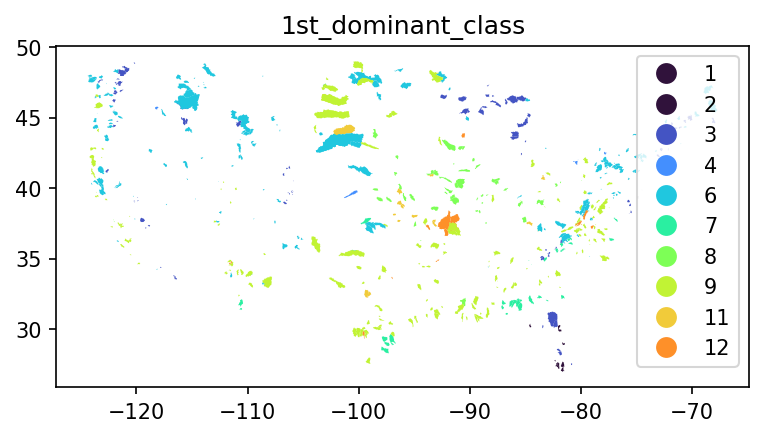

In [24]:
var_name = '1st_dominant_class'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
#gdf_camels.plot(ax=ax, color='white', edgecolor='black', lw=0.2)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo',
                norm=colors.Normalize(1, 12),
                legend=True
               );
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_soil_{var_name}.png', dpi=300)

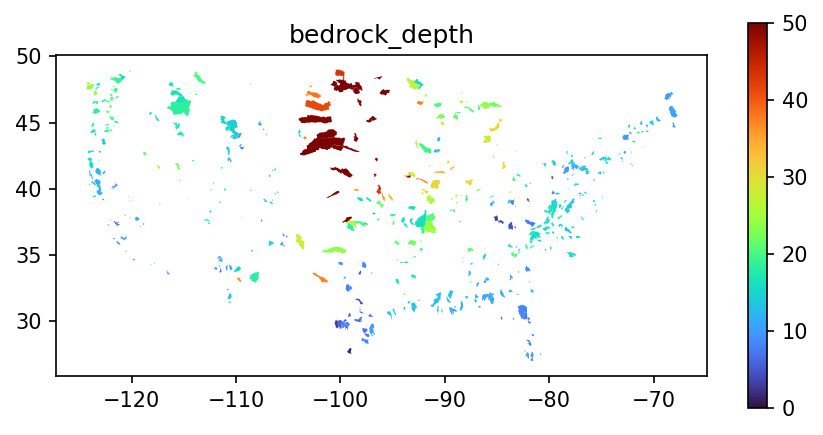

In [25]:
var_name = 'bedrock_depth'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
#gdf_camels.plot(ax=ax, color='white', edgecolor='black', lw=0.3)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo',
                norm=colors.Normalize(0, 50),
                legend=True
               );
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_soil_{var_name}.png', dpi=300)

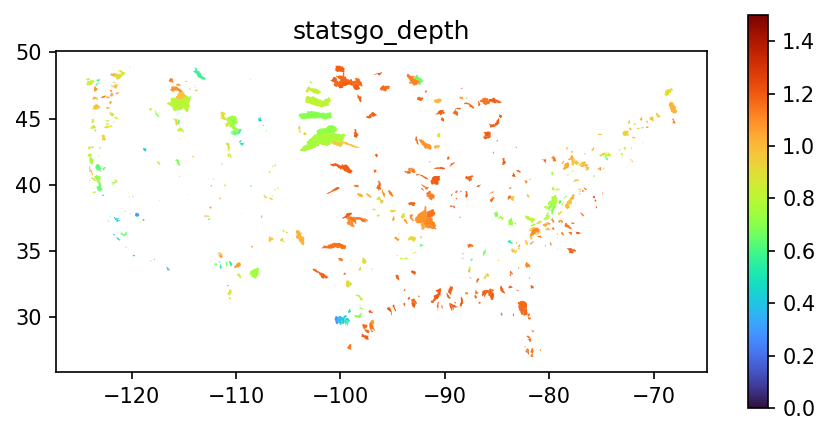

In [26]:
var_name = 'statsgo_depth'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo',
                norm=colors.Normalize(0, 1.5),
                legend=True
               );
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_soil_{var_name}.png', dpi=300)

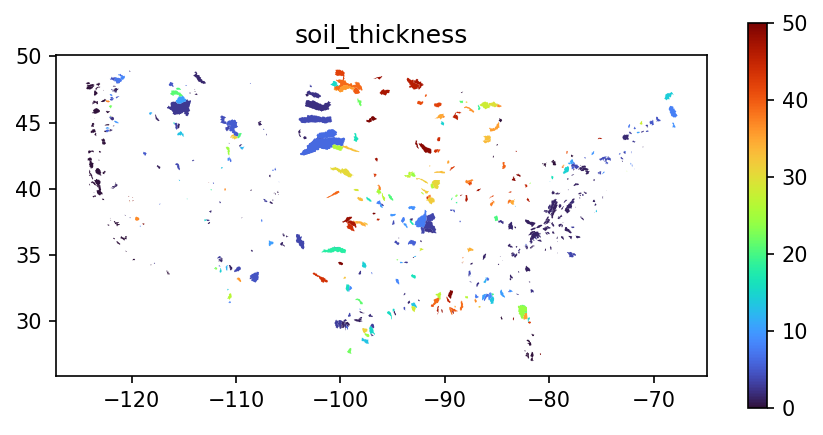

In [27]:
var_name = 'soil_thickness'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
#gdf_camels.plot(ax=ax, color='white', edgecolor='black', lw=0.3)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo',
                norm=colors.Normalize(0, 50),
                legend=True
               );
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_soil_{var_name}.png', dpi=300)

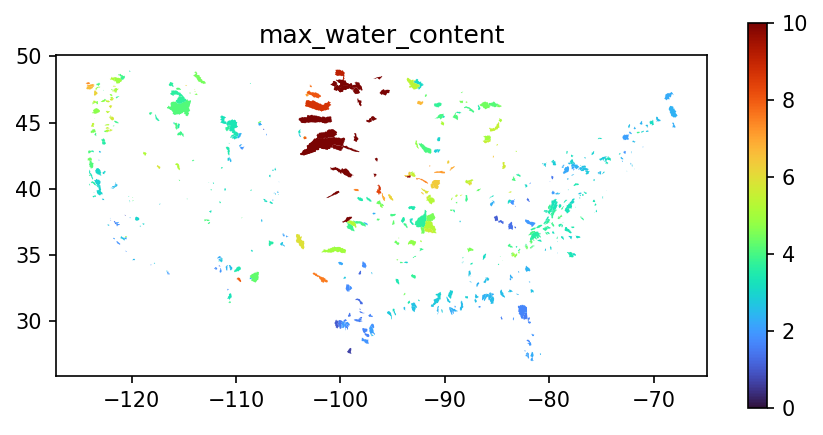

In [28]:
var_name = 'max_water_content'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
#gdf_camels.plot(ax=ax, color='white', edgecolor='black', lw=0.3)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo',
                norm=colors.Normalize(0, 10),
                legend=True
               );
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_soil_{var_name}.png', dpi=300)

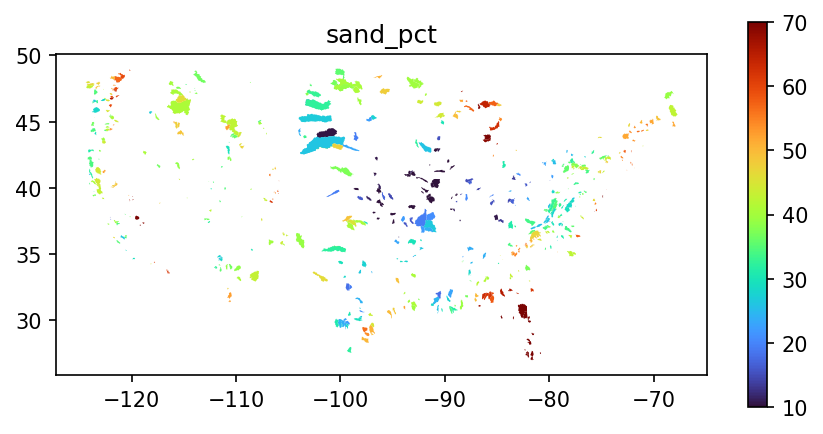

In [29]:
var_name = 'sand_pct'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
#gdf_camels.plot(ax=ax, color='white', edgecolor='black', lw=0.3)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo',
                norm=colors.Normalize(10, 70),
                legend=True
               );
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_soil_{var_name}.png', dpi=300)

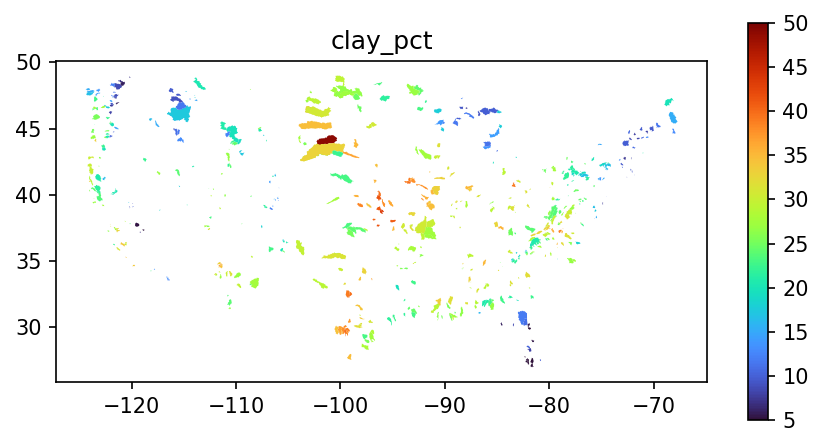

In [30]:
var_name = 'clay_pct'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
#gdf_camels.plot(ax=ax, color='white', edgecolor='black', lw=0.3)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo',
                norm=colors.Normalize(5, 50),
                legend=True
               );
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_soil_{var_name}.png', dpi=300)

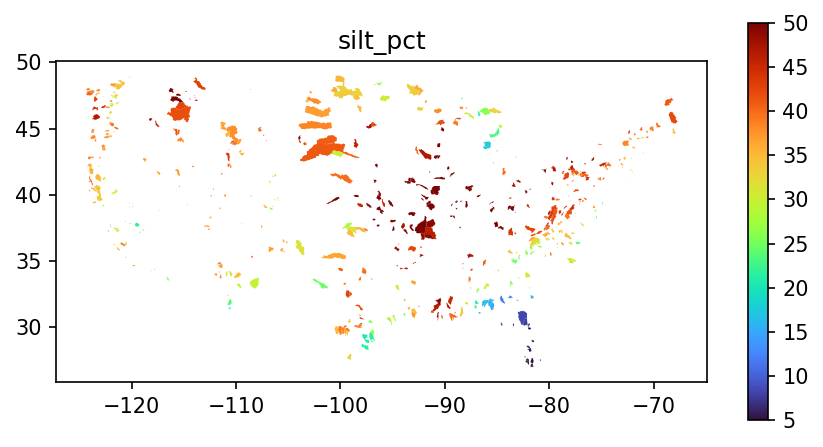

In [31]:
var_name = 'silt_pct'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
#gdf_camels.plot(ax=ax, color='white', edgecolor='black', lw=0.3)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo',
                norm=colors.Normalize(5, 50),
                legend=True
               );
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_soil_{var_name}.png', dpi=300)

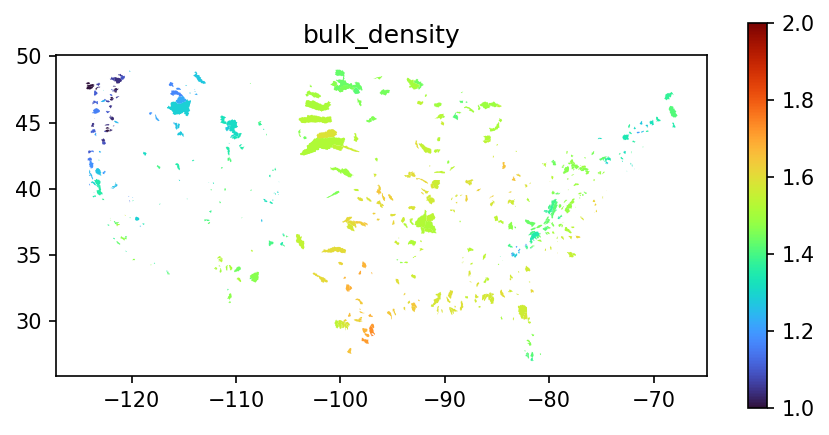

In [32]:
var_name = 'bulk_density'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
#gdf_camels.plot(ax=ax, color='white', edgecolor='black', lw=0.3)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo',
                norm=colors.Normalize(1, 2),
                legend=True
               );
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_soil_{var_name}.png', dpi=300)

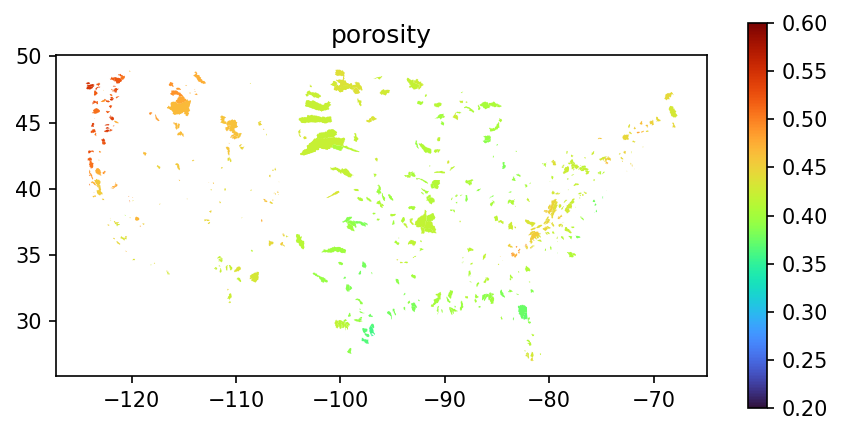

In [34]:
var_name = 'porosity'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo',
                norm=colors.Normalize(0.2, 0.6),
                legend=True
               );
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_soil_{var_name}.png', dpi=300)

In [ ]:
var_name = 'sat_matric_potential'
fig, ax = plt.subplots(figsize=(6, 3), dpi=150)
#gdf_camels.plot(ax=ax, color='white', edgecolor='black', lw=0.3)
gdf_camels.plot(ax=ax, column=var_name, cmap='turbo',
                norm=colors.Normalize(-5, -1),
                legend=True
               );
ax.set_title(var_name);
fig.tight_layout()
plt.savefig(f'./figures/{catchment_name}_soil_{var_name}.png', dpi=300)